Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [13]:
from comet_ml import Experiment
import torch
import torchvision
import torchvision.transforms as transforms

train_portion = 0.7

#controllare che len(val) è len(train)

#hyperparameters
batch_size = 250

#pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12
pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization

root = './cifar100_data' #if not in lab
root = '../datasets/cifar100'

dataset = torchvision.datasets.CIFAR100(root=root, train=True, transform=pad_totensor_transform, download=True)
train_subset, val_subset = torch.utils.data.random_split(dataset, [int(train_portion*len(dataset)), len(dataset) - int(train_portion*len(dataset))], generator=torch.Generator().manual_seed(1))
test_dataset = torchvision.datasets.CIFAR100(root=root, train=False, transform=pad_totensor_transform)


train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



Files already downloaded and verified


torch.Size([250, 3, 32, 32]) torch.Size([250])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


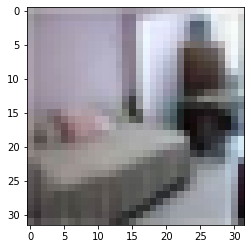

In [14]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

import matplotlib.pyplot as plt

img_sample = samples[0]
print(img_sample.shape)
print(img_sample.shape)
plt.imshow(img_sample.permute(1, 2, 0))
plt.show()

**Training loop**

In [20]:
from mlp_mixer import *
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import json

In [16]:
def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted, dim=1)
    return accuracy_score(predicted, true_labels)

def generate_folder():
    import time
    import os
    import os.path
    datetime = time.strftime("%Y%m%d-%H%M%S")

    folder = f"./models/{datetime}/"
    os.chdir(".")
    print("current dir is: %s" % (os.getcwd()))

    if os.path.isdir(folder):
        print("Exists")
    else:
        os.mkdir(folder)
    return folder

#def save_model(model, path):
#    filename = path + f"{filename}.pth"
#    print(filename)
#    torch.save(model.state_dict(), filename)    

In [23]:

experiment = Experiment(
    api_key="xX6qWBFbiOreu0W3IrO14b9nB",
    project_name="mlp-mixer",
    workspace="wedrid",
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_width_height = img_sample.shape[1]
patch_dims = 4
# variable_name = value #paper value
n_channels = 10 #100 #512
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
num_layers = 3 #8
mlp_dc_dimension = 32 #1024 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = 32 #128 #256 # ds è la dimensione del token mixing (il primo)

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension) #in this case 2 patches 16x16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

num_epochs = 10
steps_total = len(train_loader)

#ATTENZIONE: CAMBIARE IPERPARAMETRI ***PRIMAAAA*** DEL DICT SUCCESSIVO

hyper_params = {
    "train_size": len(train_loader),
    "validation_size": len(val_loader),
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "steps": steps_total,
    "batch_size": batch_size,
    "image_width_and_height": image_width_height,
    "patch_width_and_height": patch_dims,
    "hidden_dim_size (n_channels)": n_channels,
    "number_of_layers": num_layers,
    "mlp_dc_dimension": mlp_dc_dimension,
    "mlp_ds_dimension": mlp_ds_dimension
}

experiment.log_parameters(hyper_params)
model_path = generate_folder()
with open(model_path+"/params.json", "w") as file:
    json.dump(hyper_params, file, indent=4)

# training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_accuracy = 0
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        # [100, 3, 36, 36] is what is returned by iterator
        images = images.to(device)
        true_labels = labels.to(device)
        
        # forward pass
        predicted = model(images)
        loss = loss_func(predicted, true_labels)
        train_accuracy += get_accuracy(predicted, true_labels)

        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if False and (i+1) % 100:
            print(f'epoch: {epoch+1} of {num_epochs}, step {i+1} of {steps_total}, loss = {loss.item():.4f}')
    print(f"Loss of epoch {epoch+1}: {loss.item():.4f}")
    train_accuracy /= len(train_loader)
    experiment.log_metric("train epoch loss", loss.item(), step=epoch)
    experiment.log_metric("mean train epoch accuracy", train_accuracy, step=epoch)
    # validation
    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        for i, (images, labels) in enumerate(tqdm(val_loader)):
            # [100, 3, 36, 36] is what is returned by iterator
            images = images.to(device)
            true_labels = labels.to(device)
            
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, true_labels)
            val_accuracy += get_accuracy(predicted, true_labels)
        val_accuracy /= len(val_loader)
        experiment.log_metric("val epoch loss", loss.item(), step=epoch)
        experiment.log_metric("mean val epoch accuracy", val_accuracy, step=epoch)
    
    if epoch % 20 == 0:
        torch.save(model.state_dict(), model_path + f"checkpoint_epch_{epoch}.pth")
torch.save(model.state_dict(), model_path + f"final.pth")


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wedrid/mlp-mixer/065184557eb84f91beabc42224a8fe78
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     mean train epoch accuracy [10] : (0.022085714285714302, 0.13248571428571423)
COMET INFO:     mean val epoch accuracy [10]   : (0.03373333333333336, 0.13133333333333333)
COMET INFO:     train epoch loss [10]          : (3.595264196395874, 4.48098611831665)
COMET INFO:     val epoch loss [10]            : (3.748150587081909, 4.461355209350586)
COMET INFO:   Parameters:
COMET INFO:     batch_size                   : 250
COMET INFO:     epochs                       : 10
COMET INFO:     hidden_dim_size (n_channels) : 10
COMET INFO:     image_width_and_height       : 32
COMET INFO:     learning_rate                : 0.001
COMET INFO:     mlp_dc_di

current dir is: /Users/edrid/Desktop/Machine learning/Project/mlp_mixer


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 1: 4.5185


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 2: 4.2359


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 3: 4.0947


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 4: 3.8404


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 5: 3.8337


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 6: 3.7143


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 7: 3.6156


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 8: 3.5582


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 9: 3.5231


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Loss of epoch 10: 3.5575


  0%|          | 0/60 [00:00<?, ?it/s]

In [19]:
examples = iter(train_loader)
images, labels = examples.next()

# metrics trial
images = images.to(device)
labels = labels.to(device)

# forward pass
outputs = model(images)
loss = loss_func(outputs, labels)

#da mettere nel ciclo
print(outputs.shape)

#####
predicted = torch.argmax(outputs, dim=1)
accuracy = accuracy_score(predicted, labels)
print(f'Accuracy {accuracy}')
#####
print(predicted.shape)
print(predicted)


torch.Size([250, 100])
Accuracy 0.22
torch.Size([250])
tensor([24, 41, 14,  1, 89, 95, 16, 20, 30, 30, 57, 27,  8, 68, 71, 40, 82, 70,
        47, 93, 24, 62, 91, 17, 33, 90, 71, 20, 87,  7, 23, 70,  5, 68, 41, 91,
        17, 82, 33, 97, 73, 52,  4, 82, 52, 64, 42, 71, 38, 36, 92, 30, 90,  0,
        60, 76, 85, 67, 76, 95, 35, 67, 33, 69, 36, 37, 63, 20, 92, 86, 64, 28,
        68,  0, 48, 52, 21, 28, 37, 56, 53, 20, 52, 24, 56, 60, 51, 62, 48, 53,
        96, 91, 39, 87, 61,  8, 23, 68, 44, 61,  6, 59, 93,  9, 42, 22, 63, 68,
        96, 24, 88, 99, 75, 76, 60, 85, 43, 12, 33, 97, 52, 53, 76, 48, 63, 17,
        22, 15, 91, 39, 62, 68, 51, 83, 33, 82, 74,  2, 12, 74, 85, 83, 64, 28,
        53, 12, 88, 61, 83, 61, 39,  8, 38, 62, 85, 61, 49, 63, 49, 18, 85,  5,
        24, 66, 98, 53, 56, 87, 42, 31, 91, 61, 64, 69, 45, 37, 94, 61, 47, 94,
         6, 56, 12, 60,  5, 76, 14, 41, 88, 17, 67, 21,  9, 29, 16, 85, 79, 41,
        79,  2, 65, 23, 12, 36, 53, 93, 96, 86, 73, 61, 27, 63, 1